In [4]:
import torch
import torch.nn as nn
import numpy as np
import argparse
import math
import os
import time

# I evaluate model on CPU because of the memory issues
# 50k samples were used at every training iteration
# model was first trained with Adam optimiser and then
# retrained with Rprop (lower than default learning rate)
# to achieve better accuracy this notebook show that 
# model is able to learn target vanilla prices up to almost
# arbitrary accuracy

# This notebook shows that re-evaluating the model using
# larger number of fixed samples than the ones used in 
# training still gives the values that closely 
# match the target vanilla prices

torch.set_default_tensor_type('torch.FloatTensor')
# number of samples is double below (because of antithetics)
MC_samples=500000
n_steps=48

# fix the seeds for reproducibility
np.random.seed(12)
rand_matrix_1 = np.random.normal(size=(MC_samples, n_steps))
np.random.seed(21)
rand_matrix_2 = np.random.normal(size=(MC_samples, n_steps))

# generate subdivisions of 2 year interval
timegrid = torch.linspace(0,2,49) 

# generate antithetics and pass to torch
rand_matrix_1 = np.append(rand_matrix_1,-rand_matrix_1,axis=0)
rand_matrix_2 = np.append(rand_matrix_2,-rand_matrix_2,axis=0)

z = []
z1 = []

if torch.cuda.is_available():
    #device=torch.cuda.current_device()
    device='cpu'
for t in range(len(timegrid)-1):
    z.append(torch.tensor(rand_matrix_1[:,t],device=device).float())
    z1.append(torch.tensor(rand_matrix_2[:,t],device=device).float())
    
rand_matrix_1=0
rand_matrix_2=0
        
#Load market prices
ITM_call=torch.load('ITM_call.pt').to(device=device)
ITM_put=torch.load('ITM_put.pt').to(device=device)
OTM_call=torch.load('OTM_call.pt').to(device=device)
OTM_put=torch.load('OTM_put.pt').to(device=device)

target=torch.cat([OTM_call, OTM_put, ITM_call, ITM_put],0).to(device='cpu')


class Net_timestep(nn.Module):
    def __init__(self, dim, nOut, n_layers, vNetWidth, activation = "relu"):
        super(Net_timestep, self).__init__()
        self.dim = dim
        self.nOut = nOut
        
        if activation!="relu" and activation!="tanh":
            raise ValueError("unknown activation function {}".format(activation))
        if activation == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Tanh()
        
        self.i_h = self.hiddenLayerT1(dim, vNetWidth)
        self.h_h = nn.ModuleList([self.hiddenLayerT1(vNetWidth, vNetWidth) for l in range(n_layers-1)])
        self.h_o = self.outputLayer(vNetWidth, nOut)
        
    def hiddenLayerT0(self,  nIn, nOut):
        layer = nn.Sequential(
                              nn.Linear(nIn,nOut,bias=True),
                              self.activation)   
        return layer
    
    def hiddenLayerT1(self, nIn, nOut):
        layer = nn.Sequential(nn.Linear(nIn,nOut,bias=True), 
                              self.activation)   
        return layer
    
    
    def outputLayer(self, nIn, nOut):
        layer = nn.Sequential(nn.Linear(nIn, nOut,bias=True))
        return layer
    
    def forward(self, S):
        h = self.i_h(S)
        for l in range(len(self.h_h)):
            h = self.h_h[l](h)
        output = self.h_o(h)
        return output

class Net_SDE_CV(nn.Module):
    
    def __init__(self, dim, timegrid, strikes_call, strikes_put, ITM_call, OTM_call, ITM_put, OTM_put, n_layers, vNetWidth, device):
        
        super(Net_SDE_CV, self).__init__()
        self.dim = dim
        self.timegrid = timegrid
        self.device = device
        self.strikes_call = strikes_call
        self.strikes_put = strikes_put
        self.diffusion =Net_timestep(dim=dim+2, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth)
        self.driftV = Net_timestep(dim=dim+2, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth)
        self.diffusionV = Net_timestep(dim=dim+2, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth)
        self.diffusionV1 = Net_timestep(dim=dim+2, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth)
        
    def forward(self, S0, V0, rate,BS_vol, indices, z,z1, MC_samples): 
        batch_size = S0.shape[0]
        S_old = torch.repeat_interleave(S0, MC_samples, dim=0)
        BS_old = torch.repeat_interleave(S0, MC_samples, dim=0)
        V_old = torch.repeat_interleave(V0, MC_samples, dim=0)  
        K_call = self.strikes_call
        K_put = self.strikes_put
        zeros = torch.repeat_interleave(torch.zeros(1,1), MC_samples, dim=0)
        average_SS = torch.Tensor()
        average_SS1 = torch.Tensor()
        average_SS_OTM = torch.Tensor()
        average_SS1_ITM = torch.Tensor()
        average_IVs = torch.Tensor()
        h = self.timegrid[1]-self.timegrid[0]
        countmat=-1
        
        for i in range(1, len(self.timegrid)):
            dW = (torch.sqrt(h) * z[i-1]).reshape(MC_samples,1)
            dW1 = (torch.sqrt(h) * z1[i-1]).reshape(MC_samples,1)
            current_time = torch.ones(batch_size, 1)*self.timegrid[i-1]
            input_time  = torch.repeat_interleave(current_time, MC_samples,dim=0)
            inputNN = torch.cat([input_time.reshape(MC_samples,1),S_old, V_old],1)
            S_new =S_old + S_old*rate*h + self.diffusion(inputNN)*dW 
            S_new = torch.cat([S_new,zeros],1)
            S_new=torch.max(S_new,1,keepdim=True)[0]
            S_old = S_new
            V_new = V_old + self.driftV(inputNN)*h +self.diffusionV(inputNN)*dW + self.diffusionV1(inputNN)*dW1
            V_old = V_new
            
            if int(i) in indices:
                countmat+=1
                Z_new=torch.Tensor()
                Z_newP_ITM = torch.Tensor()
                Z_newP_OTM = torch.Tensor()
                countstrikecall=-1
                for strike in K_call:
                    countstrikecall+=1
                    strike=torch.tensor([[strike]]).float()
                    K_extended = torch.repeat_interleave(torch.ones(1,1)*strike, MC_samples, dim=0).float()
                    K_extended_put = torch.repeat_interleave(torch.ones(1,1)*K_put[countstrikecall], MC_samples, dim=0).float()
                    price = torch.cat([S_old-K_extended,zeros],1)
                    price_OTM = torch.cat([K_extended_put-S_old,zeros],1)
                    price = torch.max(price, 1, keepdim=True)[0]*torch.exp(-rate*2*i/48)
                    price_OTM = torch.max(price_OTM, 1, keepdim=True)[0]*torch.exp(-rate*2*i/48)
                    Z_new= torch.cat([Z_new,price],1)  
                    Z_newP_OTM= torch.cat([Z_newP_OTM,price_OTM],1) 
                avg_S = torch.cat([p.mean().view(1,1) for p in Z_new.T], 0)
                avg_SSP_OTM = torch.cat([p.mean().view(1,1) for p in Z_newP_OTM.T], 0)
                average_SS = torch.cat([average_SS,avg_S.T],0) #call OTM
                average_SS_OTM = torch.cat([average_SS_OTM,avg_SSP_OTM.T],0) #put OTM       
                countstrikeput=-1
                
                Z_new=torch.Tensor()
                for strike in K_put:
                    countstrikeput+=1
                    strike=torch.tensor([[strike]]).float()
                    K_extended = torch.repeat_interleave(torch.ones(1,1)*strike, MC_samples, dim=0).float()
                    K_extended_call = torch.repeat_interleave(torch.ones(1,1)*K_call[countstrikeput], MC_samples, dim=0).float()
                    price_ITM = torch.cat([K_extended_call-S_old,zeros],1)
                    price = torch.cat([S_old-K_extended,zeros],1)
                    price = torch.max(price, 1, keepdim=True)[0]*torch.exp(-rate*2*i/48)
                    price_ITM = torch.max(price_ITM, 1, keepdim=True)[0]*torch.exp(-rate*2*i/48)
                    Z_new= torch.cat([Z_new,price],1) 
                    Z_newP_ITM= torch.cat([Z_newP_ITM,price_ITM],1)                  
                    
                avg_S = torch.cat([p.mean().view(1,1) for p in Z_new.T], 0)
                avg_SSP_ITM = torch.cat([p.mean().view(1,1) for p in Z_newP_ITM.T], 0)
                average_SS1_ITM = torch.cat([average_SS1_ITM,avg_SSP_ITM.T],0)                            
                average_SS1 = torch.cat([average_SS1,avg_S.T],0)      
                    

        return torch.cat([average_SS,average_SS_OTM,average_SS1,average_SS1_ITM  ],0)  
    




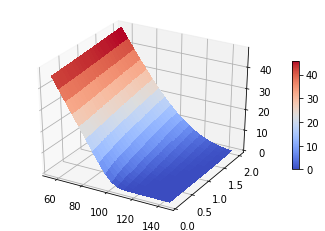

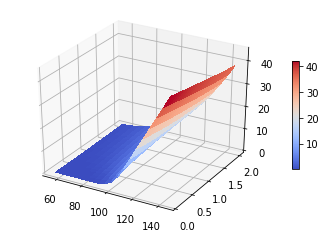

In [5]:
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt6
import matplotlib.pyplot as plt7
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
MC_samples=500000
batch_size = 1
S0 = torch.ones(batch_size, 1)*100
V0 = torch.ones(batch_size,1)*0.04
rate = torch.ones(batch_size, 1)*0.025

indices = torch.tensor([ 2,4,  6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36,
 38, 40, 42, 44, 46, 48])    


strikes_put=[55,60, 65,70,75,80,85,90,95,100]
strikes_call=[100,105,110,115,120,125,130,135, 140,145]
strikes=[55,60, 65,70,75,80,85,90,95,100,105,110,115,120,125,130,135, 140,145]

BS_vol=0.2
timegrid = torch.linspace(0,2,49)
N_steps = 22
target_timegrid= torch.linspace(1/12, 2, N_steps + 2)
fig6 = plt6.figure()
ax6 = fig6.gca(projection='3d')
fig7 = plt7.figure()
ax7 = fig7.gca(projection='3d')

#Data
X1 = strikes
X2 = strikes

mat_vec= [1/12,2/12,3/12,4/12,5/12,6/12,7/12,8/12,9/12,10/12,11/12,1,13/12,14/12,15/12,16/12,17/12,18/12,19/12,20/12,21/12,22/12,23/12,2]
Y = mat_vec
X1, Y1 = np.meshgrid(X1, Y)
X2, Y2 = np.meshgrid(X2, Y)
Z1=0
Z2=0

path = r"NN_NO_CV20kSE2.pth"
model = Net_SDE_CV(dim=1, timegrid=timegrid, strikes_call=strikes_call,strikes_put=strikes_put,ITM_call=ITM_call,OTM_call=OTM_call,ITM_put=ITM_put,OTM_put=OTM_put, n_layers=2, vNetWidth=20, device='cpu')
model.load_state_dict(torch.load(path), strict=False)

model=model.to(device='cpu')
Z=model(S0, V0, rate,BS_vol, indices, z,z1, 2*MC_samples).float().to(device='cpu')
Z=Z.detach().numpy()


Call_NN=np.concatenate([Z[48:72,0:9],Z[0:24,0:10]],1)
Put_NN=np.concatenate([Z[24:48,0:9],Z[72:96,0:10]],1)


Call_ITM=ITM_call.detach().numpy()
Call_OTM=OTM_call.detach().numpy()
Put_ITM=ITM_put.detach().numpy()
Put_OTM=OTM_put.detach().numpy()

#Z3=np.concatenate([Call_ITM,Call_OTM[0:24,1:10]],1)
#Z4=np.concatenate([Put_OTM,Put_ITM[0:24,1:10]],1)

Z3 = Call_NN
Z4 = Put_NN

# Plot the Model surface.
surf1 = ax6.plot_surface(X1, Y1, Z3, cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf2 = ax7.plot_surface(X1, Y2, Z4, cmap=cm.coolwarm,  linewidth=0, antialiased=False)

# add colorbar
fig6.colorbar(surf1, shrink=0.5, aspect=15)
fig7.colorbar(surf2, shrink=0.5, aspect=15)
plt6.show()
plt7.show()

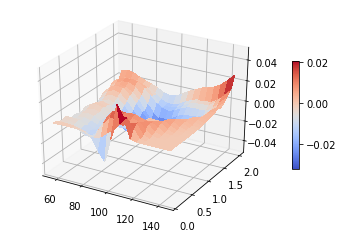

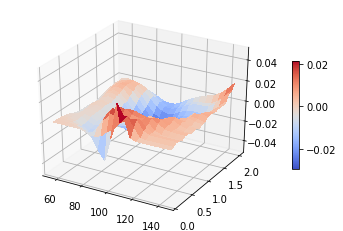

In [7]:
import matplotlib.pyplot as plt8
import matplotlib.pyplot as plt9

strikes=[55,60, 65,70,75,80,85,90,95,100,105,110,115,120,125,130,135, 140,145]

fig8 = plt8.figure()
ax8 = fig8.gca(projection='3d')
fig9 = plt9.figure()
ax9 = fig9.gca(projection='3d')

ax8.set_zlim3d(-0.05,0.05)
ax9.set_zlim3d(-0.05,0.05)

mat_vec= [1/12,2/12,3/12,4/12,5/12,6/12,7/12,8/12,9/12,10/12,11/12,1,13/12,14/12,15/12,16/12,17/12,18/12,19/12,20/12,21/12,22/12,23/12,2]
Y = mat_vec
X3, Y3 = np.meshgrid(strikes, Y)
X4, Y4 = np.meshgrid(strikes, Y)

Call_NN=np.concatenate([Z[48:72,0:9],Z[0:24,0:10]],1)
Put_NN=np.concatenate([Z[24:48,0:9],Z[72:96,0:10]],1)
Call_ITM=ITM_call.detach().numpy()
Call_OTM=OTM_call.detach().numpy()
Put_ITM=ITM_put.detach().numpy()
Put_OTM=OTM_put.detach().numpy()

Z5=Call_NN-np.concatenate([Call_ITM,Call_OTM[0:24,1:10]],1)
Z6=Put_NN-np.concatenate([Put_OTM,Put_ITM[0:24,1:10]],1)

# Plot the Model target difference
surf1 = ax8.plot_surface(X3, Y3, Z5, cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf2 = ax9.plot_surface(X4, Y4, Z6, cmap=cm.coolwarm,  linewidth=0, antialiased=False)

# add colorbar
fig8.colorbar(surf1, shrink=0.5, aspect=15)
fig9.colorbar(surf2, shrink=0.5, aspect=15)
plt8.show()
plt9.show()